# Write function to read in external GOES and ACE fluxes

Main things to do here: 
- Efficient read in
- Converting the timestamp to some epoch
- Converting OBMT to some epoch

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
def read_flux_external(filenames):
    """
    Takes a list of external flux filenames and returns the acquisition times and fluxes in different bands.
    """
    import numpy as np
    import csv
    from astropy.time import Time
    
    # read in the raw data - all strings
    rawdat = []
    for fname in filenames:
        with open(fname, 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=' ')
            for row in reader:
                rawdat.append(row)
                
    # convert the first columns (i.e. the timestamp) into an astropy time object
    times = [rawdat[ii][0] for ii in range(len(rawdat))]
    times = np.array([t[:-2] + ':' + t[-2:] + ':00' for t in times])
    times = Time(times, format='isot', scale='utc')
    
    # turn all the fluxes into one array
    ncols = len(times)
    fluxes = np.transpose(np.array([rawdat[ii][1:ncols] for ii in range(len(rawdat))]).astype('float'))
    
    return times, fluxes

In [3]:
def OBMT_apyTime(obmt_in):
    """Assign a given OBMT to astropy time objects"""
    from astropy.time import Time
    # reference time: UNIX and OBMT at 2014-01-01T00:00:00
    unix_ref = 1393445605
    obmt_ref = 10454400000000000
    
    unix_out = unix_ref + (obmt_in - obmt_ref)/1e9
    
    out = Time(unix_out, format='unix')
    out.format = 'isot' # may not matter
    
    return out

In [54]:
t_ace, f_ace = read_flux_external(['../../datasets/external/ACE/ACE_2017-07.txt'])
valid_ace = f_ace[0]>0

t_goes, f_goes = read_flux_external(['../../datasets/external/GOES/GOES_2017-07.txt'])
valid_goes = f_goes[0]>0

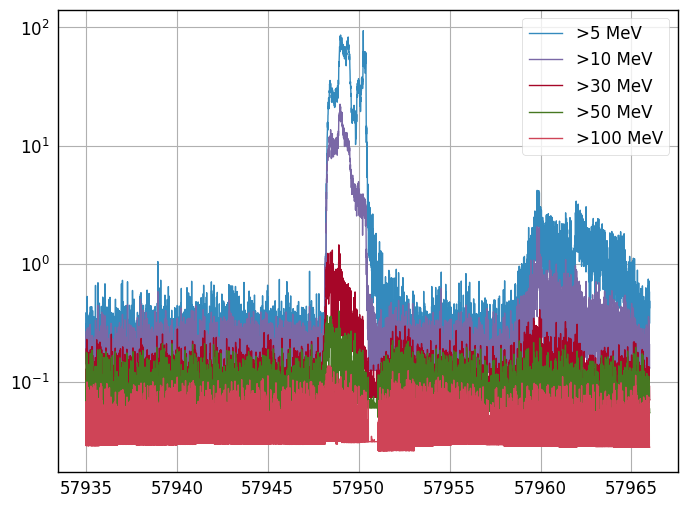

In [55]:
#plt.plot(t_goes.mjd[valid_goes], f_goes[0][valid_goes], label='>1 MeV')
plt.plot(t_goes.mjd[valid_goes], f_goes[1][valid_goes], label='>5 MeV')
plt.plot(t_goes.mjd[valid_goes], f_goes[2][valid_goes], label='>10 MeV')
plt.plot(t_goes.mjd[valid_goes], f_goes[3][valid_goes], label='>30 MeV')
plt.plot(t_goes.mjd[valid_goes], f_goes[4][valid_goes], label='>50 MeV')
plt.plot(t_goes.mjd[valid_goes], f_goes[5][valid_goes], label='>100 MeV')
plt.legend(loc='best')
plt.yscale('log')

(0.11700000000000001, 1000)

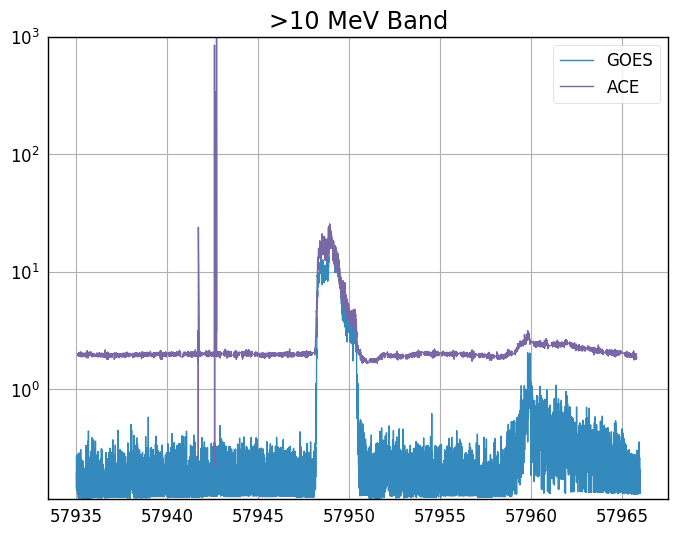

In [56]:
plt.plot(t_goes.mjd[valid_goes], f_goes[2][valid_goes], label='GOES')
plt.plot(t_ace.mjd[valid_ace], f_ace[0][valid_ace], label='ACE')

plt.title(">10 MeV Band")
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(0,1000)

(0.062199999999999998, 1000)

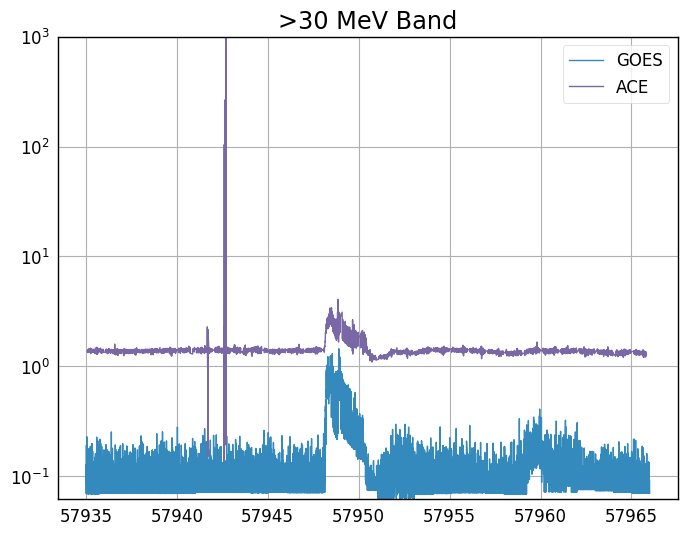

In [57]:
plt.plot(t_goes.mjd[valid_goes], f_goes[3][valid_goes], label='GOES')
plt.plot(t_ace.mjd[valid_ace], f_ace[1][valid_ace], label='ACE')

plt.title(">30 MeV Band")
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(0,1000)

On geometry factors:

GOES: page 2-3 https://goes.gsfc.nasa.gov/text/databook/section05.pdf

ACE: page 3, 18 https://link.springer.com/content/pdf/10.1023%2FA%3A1005027929871.pdf

A good source of information and definitions is this book, starting page 59:
https://books.google.nl/books?id=3pBNNEykLIIC

There, the differential flux given in these two detectors is simply defined as j(alpha), which has a directionality, unit parts/cm^2/s/steradian. So, the particle flux I measure in Gaia is just achieved by integrating over the angular distro (there is also a j(E,alpha), you can guess what that is).

To go from your raw counts to j(alpha), you need to know the sensor area as well as the solid angle of the collimator, then you can just divide - the geometry factor would be the product of the two. This can, of course, also be a factor of E.

My problem: I don't have a collimator as such on Gaia. Well, I do: it's just the entire mass model of Gaia, which - let's just say - I don't a priori know. It would also be heavily a function of energy...

To get the omnidirectional flux, we just need to integrate over the angular distribution in spherical coordinates. Assuming (!) that the flux can come from any direction, this would equal a multiplication by $4 \pi$.

Obviously, this is not especially true for a solar flare - just for the GCRs, if we ignore the fact that Gaia will have some directional shielding.

As such, our goal of comparing the exact numbers in the fluxes between our spacecraft during solar events is probably futile, unless I include for Gaia at the very least stuff like the projected effective area of the detector, which would be a function of the spin phase.

All in all, I probably should not compare my solar quiet values with GOES and ACE either - since they are in the Van Allen belts and directly sampling the solar wind outside the magnetosphere, respectively.

It might be smart to look at the SREMs of Herschel and Planck for the baseline (although it will have evolved in the time between), and to GOES and ACE for the arrival time/morphologies of the flare.

One further problem: The other detectors are small ones with a collimator, essentially measuring a small part of the surface of a sphere. Meanwhile, mine is a rotating slab in TDI readout mode - which is to say that my values may be somewhat biased.